# ClusterEnsemble demonstration
Some example usage of how to build up a dataframe of galaxy cluster properties, including NFW halo profiles. Each cluster is treated as an individual, meaning we track its individual mass and redshift, and other properties. This is useful for fitting a stacked weak lensing profile, for example, where you want to avoid fitting a single average cluster mass.

In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from astropy import units
from matplotlib import pyplot as plt

import seaborn as sns; sns.set() 

In [2]:
from clusters import ClusterEnsemble

### Create a ClusterEnsemble object by passing in a numpy array (or list) of redshifts

In [3]:
z = np.array([0.1,0.2,0.3])
c = ClusterEnsemble(z)
c.describe

'Ensemble of galaxy clusters and their properties.'

### Display what we have so far
Below the DataFrame (which so far only contains the cluster redshifts), we see the default assumptions for the power-law slope and normalization that will be used to convert richness $N_{200}$ to mass $M_{200}$. We'll see how to change those parameters below.

In [4]:
c.show()


Cluster Ensemble:


,z
0,0.1
1,0.2
2,0.3



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Add richness values to the dataframe
This step will also generate $M_{200}$, $r_{200}$, $c_{200}$, scale radius $r_s$, and other parameters, assuming the scaling relation given below.

In [5]:
n200 = np.ones(3)*20.
c.update_richness(n200)
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.1,20,2.700000e+13,0.612222,5.821359,12329.828385,0.105168
1,0.2,20,2.700000e+13,0.591082,5.627032,11398.735247,0.105043
2,0.3,20,2.700000e+13,0.569474,5.426060,10482.820471,0.104952



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Access any column of the dataframe as an array
Notice that [astropy units](http://docs.astropy.org/en/stable/units/) are present for the appropriate columns.

In [6]:
print('z: \t', c.z)
print('n200: \t', c.n200)
print('r200: \t', c.r200)
print('m200: \t', c.m200)
print('c200: \t', c.c200)
print('rs: \t', c.rs)

z: 	 [ 0.1  0.2  0.3]
n200: 	 [ 20.  20.  20.]
r200: 	 [ 0.61222163  0.59108187  0.56947428] Mpc
m200: 	 [  2.70000000e+13   2.70000000e+13   2.70000000e+13] solMass
c200: 	 [ 5.82135877  5.62703234  5.42605953]
rs: 	 [ 0.10516817  0.10504327  0.10495172] Mpc


###If you don't want units, you can get just the values

In [7]:
c.r200.value

array([ 0.61222163,  0.59108187,  0.56947428])

### Change the redshifts or richness values
These changes will propogate to all redshift-dependant or richness-dependant cluster attributes, as appropriate.

In [8]:
c.update_z(np.array([0.4,0.5,0.6]))
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,20,2.700000e+13,0.526483,5.041283,8859.107775,0.104434
2,0.6,20,2.700000e+13,0.505701,4.864887,8170.244874,0.103949



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


In [9]:
c.update_richness([20,30,40])
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,30,4.763120e+13,0.636151,4.795641,7909.142281,0.132652
2,0.6,40,7.125343e+13,0.698834,4.477974,6777.240275,0.156060



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Change the parameters in the mass-richness relation
Either or both of the keyword parameters "slope" and "norm" can be passed to the update_massrichrelation() method.

In [10]:
c.update_massrichrelation(slope = 1.5)
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,30,4.960217e+13,0.644807,4.778560,7845.536637,0.134938
2,0.6,40,7.636753e+13,0.715169,4.451545,6687.866844,0.160656



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.5


### Show basic table
Perhaps we don't want the fancy pandas formatting on our table, or maybe we're not working in the Jupyter notebook.

In [11]:
c.show(notebook = False)


Cluster Ensemble:
     z  n200          m200      r200      c200      delta_c        rs
0  0.4    20  2.700000e+13  0.547827  5.229151  9630.870869  0.104764
1  0.5    30  4.960217e+13  0.644807  4.778560  7845.536637  0.134938
2  0.6    40  7.636753e+13  0.715169  4.451545  6687.866844  0.160656

Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.5


## Calculate $\Sigma(r)$ and $\Delta\Sigma(r)$ for NFW model
First select the radial bins in units of Mpc.

In [12]:
rmin, rmax = 0.1, 5. #Mpc
nbins = 50
rbins = np.logspace(np.log10(rmin), np.log10(rmax), num = nbins)
#rbins

In [13]:
%timeit c.calc_nfw(rbins)
sigma = c.sigma_nfw
dsigma = c.deltasigma_nfw

100 loops, best of 3: 15.3 ms per loop


### There is now a Python implentation of the NFW calculations 
Set the keyword parameter "use_c = False" to use python only. Currently, the Python version is only implemented for perfectly centered halos. Note that this method is significantly faster than the C code, for the perfectly centered case (because it suboptimally writes/reads to disc in the latter case). Stand by for the miscentering offset timing comparison...

In [14]:
%timeit c.calc_nfw(rbins, use_c = False)
sigma_py = c.sigma_nfw
dsigma_py = c.deltasigma_nfw

1000 loops, best of 3: 731 µs per loop


In [16]:
#check the results match
np.testing.assert_allclose(sigma_py, sigma, rtol = 10**-4)
np.testing.assert_allclose(dsigma_py, dsigma, rtol = 10**-4)

In [17]:
#sigma_py

In [18]:
sigma

<Quantity [[  1.39367876e+02,  1.26663035e+02,  1.14815477e+02,
              1.03805742e+02,  9.36101700e+01,  8.42013230e+01,
              7.55484460e+01,  6.76179810e+01,  6.03741370e+01,
              5.37794370e+01,  4.77952470e+01,  4.23823420e+01,
              3.75013710e+01,  3.31133390e+01,  2.91799890e+01,
              2.56641680e+01,  2.25301110e+01,  1.97436760e+01,
              1.72725260e+01,  1.50862520e+01,  1.31564500e+01,
              1.14567540e+01,  9.96283900e+00,  8.65237900e+00,
              7.50499500e+00,  6.50216600e+00,  5.62714400e+00,
              4.86484000e+00,  4.20171900e+00,  3.62567700e+00,
              3.12593500e+00,  2.69291700e+00,  2.31814600e+00,
              1.99413500e+00,  1.71429100e+00,  1.47282000e+00,
              1.26464200e+00,  1.08531500e+00,  9.30957000e-01,
              7.98187000e-01,  6.84060000e-01,  5.86018000e-01,
              5.01843000e-01,  4.29612000e-01,  3.67661000e-01,
              3.14550000e-01,  2.6903800

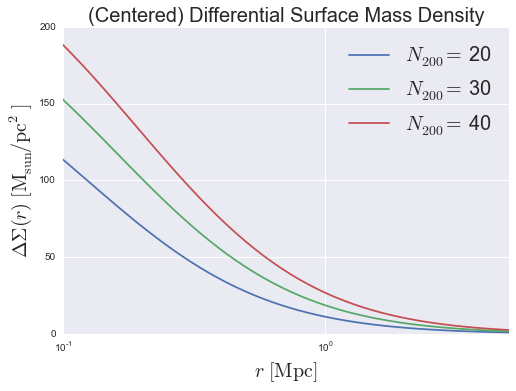

In [19]:
for rich, profile in zip(c.n200,c.deltasigma_nfw):
    plt.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
plt.xscale('log')
plt.legend(fontsize=20)

plt.xlim(rbins.min(), rbins.max())
plt.xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
plt.ylabel('$\Delta\Sigma(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', fontsize=20)
plt.title('(Centered) Differential Surface Mass Density', fontsize=20)

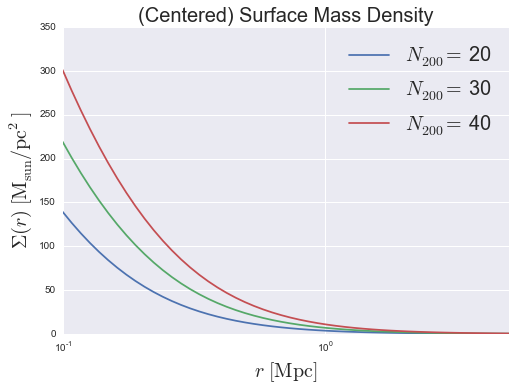

In [20]:
for rich, profile in zip(c.n200,c.sigma_nfw):
    plt.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
plt.xscale('log')
plt.legend(fontsize=20)

plt.xlim(rbins.min(), rbins.max())
plt.xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
plt.ylabel('$\Sigma(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', fontsize=20)
plt.title('(Centered) Surface Mass Density', fontsize=20)

# Calculate Miscentered NFW Profiles
First select the offsets in units of Mpc. The offset values parameterize the width of the Gaussian distribution of offsets, and is $\sigma_\mathrm{off}$ in Equation 11 of [Ford et al 2015](http://arxiv.org/abs/1409.3571).

In [21]:
offsets = np.array([0.09,0.09,0.09])
c.calc_nfw(rbins, offsets=offsets)

In [22]:
#print(c.deltasigma_offset)
#print(c.sigma_offset)

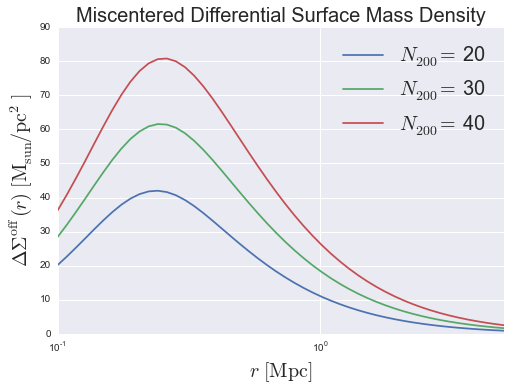

In [23]:
for rich, profile in zip(c.n200,c.deltasigma_offset):
    plt.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
plt.xscale('log')
plt.legend(fontsize=20)

plt.xlim(rbins.min(), rbins.max())
plt.xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
plt.ylabel('$\Delta\Sigma^\mathrm{off}(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', 
           fontsize=20)
plt.title('Miscentered Differential Surface Mass Density', fontsize=20)

### To Do: 
- fix bug sometimes giving Inf in first bin of smoothed profiles
- replace smd_nfw.c with cython version
- write more tests
- use decorators (@property, @setter, @deleter) instead of update_z(), for example
- option to pass in a $M_{prelim}$ and $M_{200} = a \times$ $M_{prelim}$ relation